# Session 3 : Time series models

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This third session discusses several popular models for time series : signal+noise, sinusoidal model, trend and seasonality modelling and autoregressive models. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Signal + Noise model**
4. **Sinusoidal model**
5. **Trend + Seasonality model**
6. **Autoregressive model**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats

In [2]:
mpl.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session3.npz')
x=npzfile['x']
t=npzfile['t']
Fs=1

# First investigations
N=np.size(x)
print("Number of samples : {N}".format(**locals()))
print("First mesurement : {}".format(t[0]))
print("Last mesurement : {}".format(t[-1]))

Number of samples : 235
First mesurement : 2000-01
Last mesurement : 2019-07


## 2. Exploratory study

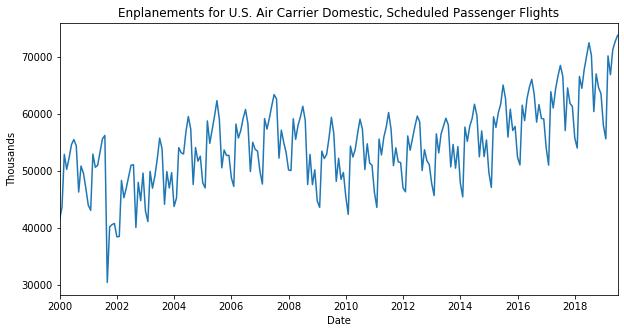

In [4]:
# x[n] as a function of the date
plt.plot(t,x)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.ylabel('Thousands')
plt.title('Enplanements for U.S. Air Carrier Domestic, Scheduled Passenger Flights')
plt.show()

In [5]:
mu=np.mean(x) #Mean
sigma2=np.var(x) #Variance (biased)
print("Empirical mean : {mu}".format(**locals()))
print("Empirical variance (biased) : {sigma2}".format(**locals()))

Empirical mean : 54518.587234042556
Empirical variance (biased) : 49556199.6806881


In [6]:
# Data renormalization
x=stats.zscore(x) # x is now zero mean and unit variance
mu=np.mean(x) #Mean
sigma2=np.var(x) #Variance (biased)
print("Empirical mean : {mu}".format(**locals()))
print("Empirical variance (biased) : {sigma2}".format(**locals()))

Empirical mean : -3.9306619425026816e-16
Empirical variance (biased) : 0.9999999999999998


## 3. Signal + Noise model

The most common model for degradation is
  $$y[n] = x[n] + b[n]$$
* $x[n]$ is the signal of interest
* $b[n]$ is the measurement noise (additive and random) 
* $y[n]$ is the measured signal
* $x[n]$ and $b[n]$ are supposed to be decorrelated

The importance of the noise component is estimated by the Signal-to-Noise Ratio (SNR), often given in décibels (dB)
$$SNR_{dB} = 10\log_{10} \left(\frac{\sigma^2_x}{\sigma^2_b}\right)$$
 

In [7]:
# Computation of the degraded signal
SNR=5 #SNR in dB
sigma2x=np.var(x)
sigma2b=sigma2x*np.power(10,-SNR/10)
print("SNR : {SNR} dB".format(**locals()))
print("Signal variance : {sigma2x}".format(**locals()))
print("Noise variance : {sigma2b}".format(**locals()))
b=np.sqrt(sigma2b)*np.random.randn(N) # additive white Gaussian noise (AWGN)
y=x+b

SNR : 5 dB
Signal variance : 0.9999999999999998
Noise variance : 0.3162277660168379


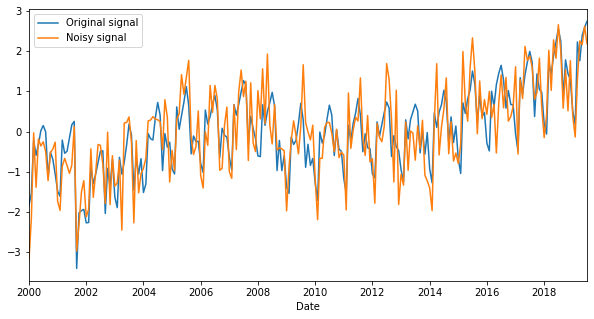

In [8]:
# Plots of x[n] and y[n]
plt.plot(t,x)
plt.plot(t,y)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Original signal', 'Noisy signal'))
plt.show()

In [9]:
# Periodogram function
def periodogram(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f   

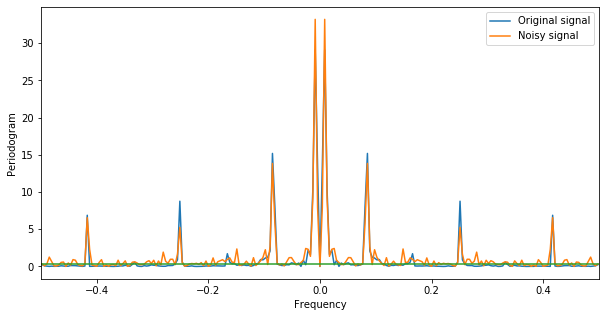

In [10]:
# Plots of the periodograms of x[n] and y[n]
Gammax,f=periodogram(x,Fs)
Gammay,f=periodogram(y,Fs)
plt.plot(f,Gammax)
plt.plot(f,Gammay)
plt.ylabel('Periodogram')
plt.xlabel('Frequency')
plt.xlim((-Fs/2,Fs/2))
plt.legend(('Original signal', 'Noisy signal'))
plt.plot([-Fs/2, Fs/2], [sigma2b ,sigma2b])
plt.show()

## 4. Sinusoidal model

For repetitive periodic signals, a common physical model is 
  $$x[n] = \sum_{i=1}^{N_h} a_i \sin\left( 2\pi (i f_0) \frac{n}{Fe} + \phi_i\right)  + b[n]$$
* $f_0$ is the fundamental frequency (in Hz)
* $i\times f_0$ is the frequency of the $i^{th}$ harmonic 
* $a_i$ and $\phi_i$ are respectively the amplitudes and phases  of harmonic $i$
* $N_h$ is the total number of harmonics
* $b[n]$ is a decorrelated white noise

The parameters can be inferred by analysing the PSD (with periodogram or correlogram) or the auto-correlation function

In [11]:
# Biased estimator of the autocorrelation function
# lags are comprised between -maxLags and +maxLags
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

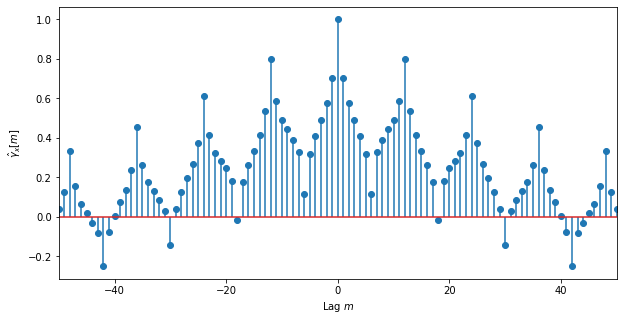

Largest value : 0.9999999999999998 for m=0
Second largest value : 0.7996587302321286 for m=-12


In [12]:
# Plot the autocorrelation function
maxLags=50
gammax,lags=autocorrelation(x,maxLags)
plt.stem(lags,gammax,use_line_collection=True)
plt.xlabel('Lag $m$')
plt.xlim((-maxLags,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.show()

# Determination of the largest values
k=np.argsort(gammax)
print("Largest value : {} for m={}".format(gammax[k[-1]],lags[k[-1]]))
print("Second largest value : {} for m={}".format(gammax[k[-2]],lags[k[-2]]))

A peak can be seen at lag $m=12$, suggesting a periodicity of 12 months, hence $f_0 = \frac{1}{12}$

array([-0.00225521, -0.68196917,  0.19042417,  0.00550765, -0.1823539 ,
       -0.39190993, -0.14518186,  0.04775676, -0.09086581,  0.10085379,
       -0.33133397])

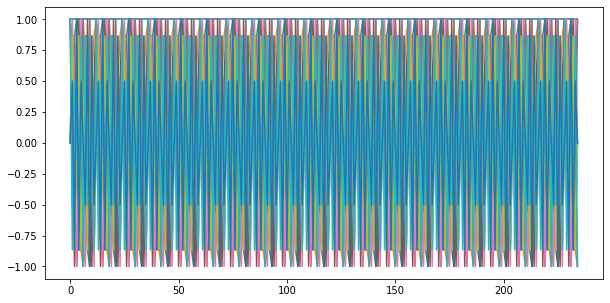

In [13]:
# Parameter inference
f0 = 1/12
N=np.size(x)
n = np.arange(N)/Fs
Nh=5 # We seek for 5 harmonics (based on the PSD)
D=np.zeros((N,2*Nh+1))
D[:,0]=np.ones(N)
for k in range(Nh):
    D[:,2*k+1]=np.cos(2*np.pi*f0*(k+1)*n)
    D[:,2*k+2]=np.sin(2*np.pi*f0*(k+1)*n)
# Display of the regression base    
plt.plot(D)
alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),x)) #Regression parameters
alpha

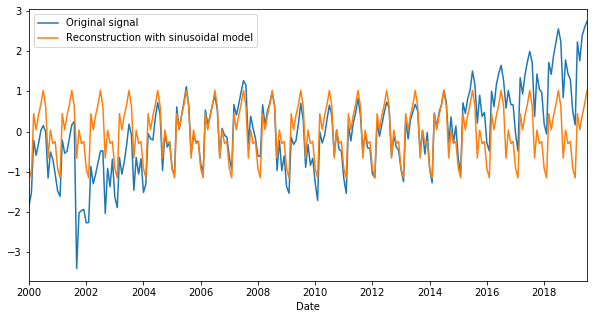

In [14]:
y=np.dot(D,alpha); #Reconstruction
plt.plot(t,x)
plt.plot(t,y)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Original signal', 'Reconstruction with sinusoidal model'))
plt.show()

## 5. Trend + Seasonality model

When the signal can be decomposed as a sum of a periodic signal (that can for instance be modelled with a sinusoidal model) and a trend (low-variations), we can write 
$$x[n] = \underbrace{\alpha_1 \beta_1\left(n T_e \right) + \ldots + \alpha_{j} \beta_j\left(n T_e \right)}_{\mbox{trend}} + \underbrace{\alpha_{j+1} \beta_{j+1}\left(n T_e \right) + \ldots + \alpha_{d} \beta_{d}\left(n T_e \right)}_{\mbox{seasonality}} + b[n]$$
where the $\alpha_i$ are weights coefficients and the $\beta_i(.)$ some regression functions.

Typically, seasonality functions are sinusoids and trend functions are some polynomial functions.

In [15]:
f0 = 1/12
N=np.size(x)
n = np.arange(N)/Fs
# We will use the same dictionary than for the sinusoidal model (for the seasonality) 
# and add some polynomials functions for the trend
Nh=5 # We seek for 5 harmonics (based on the PSD)
D=np.zeros((N,2*Nh+6))
D[:,0]=np.ones(N)
for k in range(Nh):
    D[:,2*k+1]=np.cos(2*np.pi*f0*(k+1)*n)
    D[:,2*k+2]=np.sin(2*np.pi*f0*(k+1)*n)
D[:,11]=n
D[:,12]=np.power(n,2)
D[:,13]=np.power(n,3)
D[:,14]=np.power(n,4)
D[:,15]=np.power(n,5)
    
alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),x)) #Regression parameters
alpha

array([-4.21302413e-01, -6.77144583e-01,  1.72570807e-01,  1.91285343e-04,
       -1.67720536e-01, -3.83985003e-01, -1.49962930e-01,  4.27672566e-02,
       -8.60032793e-02,  1.09003193e-01, -3.32542120e-01, -7.71292702e-02,
        2.75574410e-03, -3.20259814e-05,  1.51621235e-07, -2.49627020e-10])

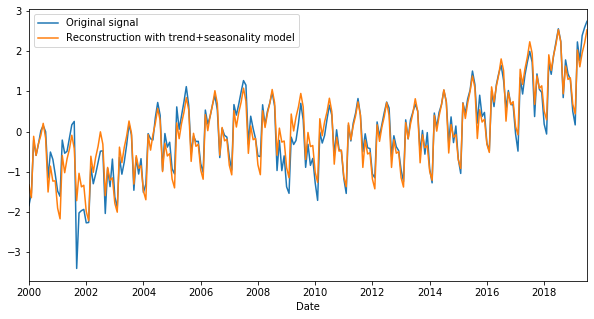

In [16]:
y=np.dot(D,alpha); #Reconstruction
plt.plot(t,x)
plt.plot(t,y)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Original signal', 'Reconstruction with trend+seasonality model'))
plt.show()

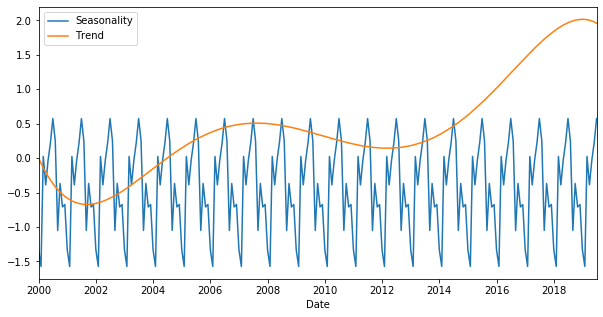

In [17]:
# Extraction of the seasonality/rend
y1=np.dot(D[:,0:11],alpha[0:11]); #Seasonality
y2=np.dot(D[:,11:16],alpha[11:16]); #Trend
plt.plot(t,y1)
plt.plot(t,y2)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Seasonality', 'Trend'))
plt.show()

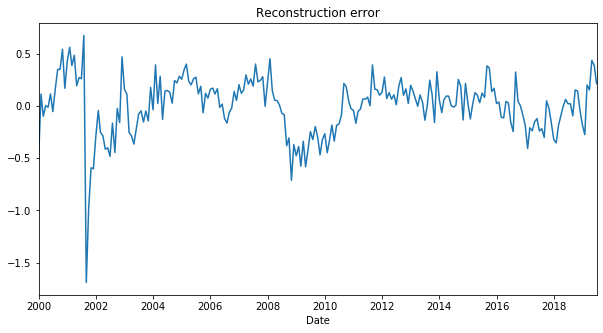

In [18]:
# Model error
y=np.dot(D,alpha); #Reconstruction
e=x-y # Reconstruction error
plt.plot(t,e)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.title('Reconstruction error')
plt.show()

The model seems fine and able to model most of the signal, except in case of strong anomalies such as 9/11 (2001) or the economical crisis (2008)

## 6. Autoregressive model

The autoregressive model of order $p$, denoted $AR(p)$, writes as
 $$x[n] = - \sum_{i=1}^p a_i x[n-i] + b[n]$$

* $p$ : order of the model
* $a_i,\ldots,a_p$ : AR coefficients
* $b[n]$ : white noise (often Gaussian)

In [39]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(x, lags=24)
model_fit = model.fit()

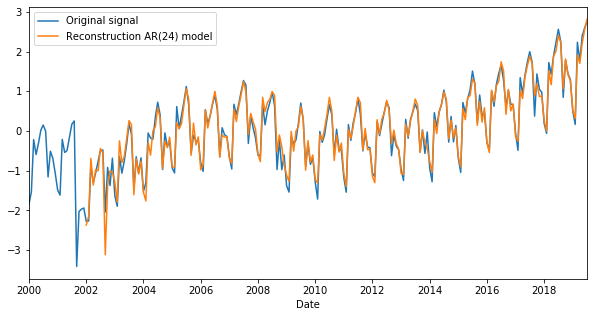

In [40]:
x_hat = model_fit.predict()
plt.plot(t,x)
plt.plot(t[24:],x_hat)
datemin = np.datetime64(t[0], 'M')
datemax = np.datetime64(t[-1], 'M')
plt.xlim((datemin,datemax))
plt.xlabel('Date')
plt.legend(('Original signal', 'Reconstruction AR(24) model'))
plt.show()

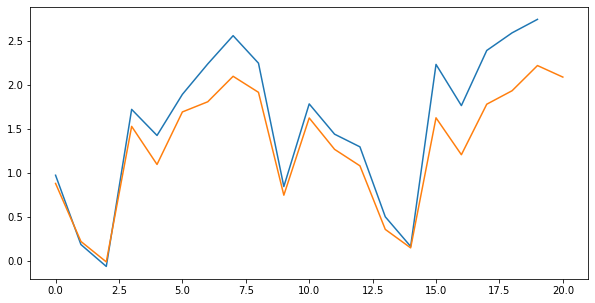

In [41]:
# Prediction of the 20 last samples from the AR parameters and the previous signal values
h=20
y = model_fit.predict(start=N-h,end=N,dynamic=True)
plt.plot(x[N-h:])
plt.plot(y)